# 1. Setup and Imports

In [13]:
# Import necessary libraries
import os
import cv2
import torch
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


In [1]:
! pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
aiohappyeyeballs             2.4.0
aiohttp                      3.10.5
aiosignal                    1.2.0
astor                        0.8.1
asttokens                    2.4.1
astunparse                   1.6.3
async-timeout                4.0.3
attrs                        24.2.0
blinker                      1.6.2
Bottleneck                   1.4.2
Brotli                       1.0.9
cachetools                   5.3.3
certifi                      2024.8.30
cffi                         1.17.1
charset-normalizer           3.3.2
click                        8.1.7
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.0
cryptography                 41.0.3
cycler                       0.11.0
debugpy                      1.8.7
decorator                    5.1.1
einops                       0.8.0
exceptiongroup               1.2.2


# 2. Data Preprocessing

### 2.1 Define Preprocessing Parameters

In [14]:
# Define constants for preprocessing
# root_folder = "videos_1"
# root_folder = "videos_3"
root_folder = "videos_5"
frame_size = (112, 112)  # Resize frames
transform = Compose([
    Resize(frame_size),
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5])  # Normalize pixel values
])

# Count the number of classes dynamically from the root folder
class_counts = {
    class_name: len(os.listdir(os.path.join(root_folder, class_name)))
    for class_name in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, class_name))
}
num_classes = len(class_counts)
print(f"Number of Classes: {num_classes}")

# Dynamically name the output folder based on the number of classes
output_folder = f"preprocessed_tensors_{num_classes}"

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)
print(f"Output Folder: {output_folder}")


Number of Classes: 5
Output Folder: preprocessed_tensors_5


### 2.2 Analyze Video Lengths

In [15]:
# Function to get video lengths
def get_video_lengths(root_folder):
    video_lengths = []
    for subfolder_name in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder_name)
        if not os.path.isdir(subfolder_path):
            continue
        for video_file in os.listdir(subfolder_path):
            if video_file.endswith((".mp4", ".avi", ".mov")):
                video_path = os.path.join(subfolder_path, video_file)
                cap = cv2.VideoCapture(video_path)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                video_lengths.append(frame_count)
                cap.release()
    return video_lengths

# Collect video lengths and determine ideal sequence length
video_lengths = get_video_lengths(root_folder)
print(f"Video lengths: {video_lengths}")
ideal_sequence_length = int(np.median(video_lengths))
print(f"Median sequence length: {ideal_sequence_length}")


Video lengths: [41, 87, 26, 52, 31, 45, 86, 108, 81, 55, 12, 55, 52, 50, 31, 28, 50, 58, 42, 65, 72, 90, 100, 58, 87, 96, 46, 94, 88, 32, 30, 86, 75, 58, 33, 39, 28, 42, 67, 63, 60, 82, 59, 62, 64, 43, 45, 87, 125, 126, 52, 96, 81, 31, 92, 20, 32, 79, 61, 102, 96, 98, 118, 100, 103, 77, 113, 80, 94, 93, 59, 27, 47, 51, 131, 118, 106, 71, 71, 94, 96, 106, 131, 34, 29, 32, 59, 43, 40, 64, 96, 70, 72, 79, 70, 70, 53, 39, 102, 35, 88, 66, 61, 33, 63, 18, 55, 55, 34, 61, 61, 46, 47, 47, 43, 72, 77, 77, 72, 50, 108, 41, 53, 120, 67]
Median sequence length: 63


### 2.3 Preprocess Videos

In [16]:
# Function to preprocess videos into tensors
def process_video_dynamic(video_path, target_length, transform):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(frame_rgb)
        transformed_frame = transform(frame_pil)
        frames.append(transformed_frame)
    cap.release()

    # Handle varying lengths
    if len(frames) < target_length:
        while len(frames) < target_length:
            frames.append(frames[-1])
    else:
        indices = np.linspace(0, len(frames) - 1, target_length, dtype=int)
        frames = [frames[idx] for idx in indices]

    video_tensor = torch.stack(frames, dim=1)
    return video_tensor

# Preprocess all videos
for subfolder_name in os.listdir(root_folder):
    subfolder_path = os.path.join(root_folder, subfolder_name)
    if not os.path.isdir(subfolder_path):
        continue
    class_output_folder = os.path.join(output_folder, subfolder_name)
    os.makedirs(class_output_folder, exist_ok=True)
    for video_file in os.listdir(subfolder_path):
        if video_file.endswith((".mp4", ".avi", ".mov")):
            video_path = os.path.join(subfolder_path, video_file)
            video_tensor = process_video_dynamic(video_path, ideal_sequence_length, transform)
            tensor_filename = os.path.splitext(video_file)[0] + ".pt"
            torch.save(video_tensor, os.path.join(class_output_folder, tensor_filename))
            print(f"Processed: {video_file}")


Processed: 05724.mp4
Processed: 05727.mp4
Processed: 05728.mp4
Processed: 05729.mp4
Processed: 05730.mp4
Processed: 05731.mp4
Processed: 05732.mp4
Processed: 05733.mp4
Processed: 05734.mp4
Processed: 05735.mp4
Processed: 05736.mp4
Processed: 05737.mp4
Processed: 05739.mp4
Processed: 05740.mp4
Processed: 05741.mp4
Processed: 05742.mp4
Processed: 05743.mp4
Processed: 05744.mp4
Processed: 05746.mp4
Processed: 05747.mp4
Processed: 05748.mp4
Processed: 05749.mp4
Processed: 05750.mp4
Processed: 65167.mp4
Processed: 68007.mp4
Processed: 70348.mp4
Processed: 08909.mp4
Processed: 08915.mp4
Processed: 08916.mp4
Processed: 08917.mp4
Processed: 08918.mp4
Processed: 08919.mp4
Processed: 08920.mp4
Processed: 08921.mp4
Processed: 08922.mp4
Processed: 08923.mp4
Processed: 08924.mp4
Processed: 08925.mp4
Processed: 08926.mp4
Processed: 08927.mp4
Processed: 08928.mp4
Processed: 08929.mp4
Processed: 65298.mp4
Processed: 65299.mp4
Processed: 65300.mp4
Processed: 67468.mp4
Processed: 67470.mp4
Processed: 68

# 3. Dataset Visualization

Loaded tensor from: preprocessed_tensors_5\before\05724.pt


C:\Users\Nhan Thai\AppData\Local\Temp\ipykernel_57416\307052957.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_tensor = torch.load(sample_tensor_path)


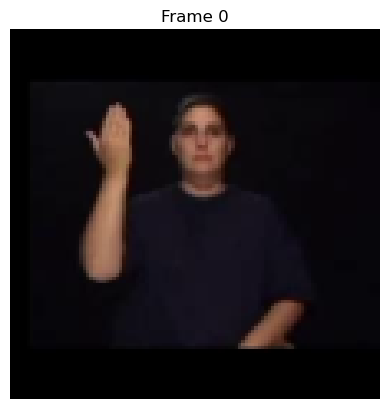

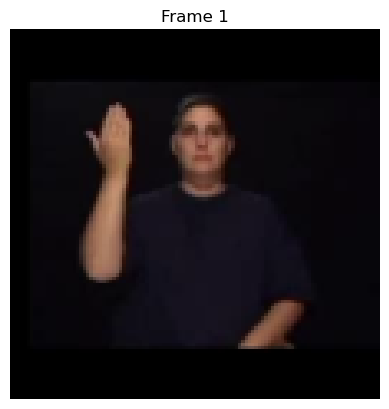

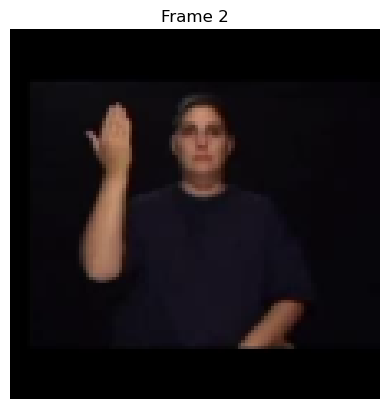

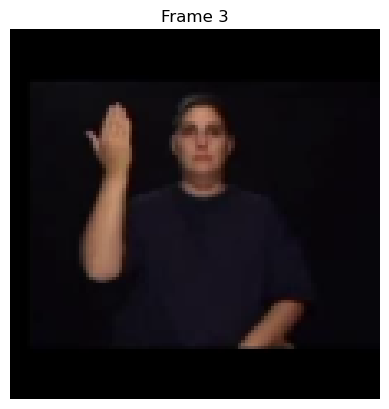

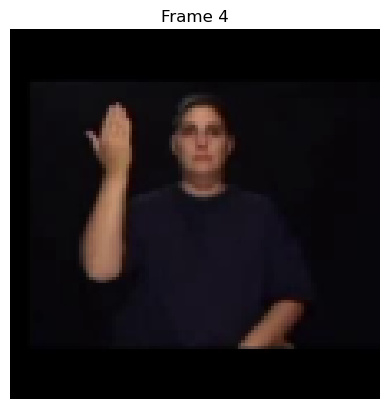

In [17]:
# Visualize some processed tensors
import matplotlib.pyplot as plt
import torch
import os

# Function to visualize frames from a tensor
def visualize_tensor(tensor, num_frames=5):
    """
    Visualizes frames from a tensor.
    - tensor: PyTorch tensor of shape (C, T, H, W)
    - num_frames: Number of frames to visualize
    """
    tensor = tensor.permute(1, 2, 3, 0)  # Rearrange to (T, H, W, C)
    tensor = (tensor * 0.5 + 0.5).clamp(0, 1)  # Denormalize
    frames = tensor[:num_frames].numpy()  # Convert to NumPy
    for i, frame in enumerate(frames):
        plt.figure()
        plt.imshow(frame)
        plt.title(f"Frame {i}")
        plt.axis("off")
    plt.show()

# Dynamically find a sample tensor
class_folder = os.listdir(output_folder)[0]  # Get the first class folder
class_path = os.path.join(output_folder, class_folder)

# Check for .pt files in the class folder
tensor_files = [f for f in os.listdir(class_path) if f.endswith(".pt")]
if tensor_files:
    sample_tensor_path = os.path.join(class_path, tensor_files[0])  # Use the first tensor file
    sample_tensor = torch.load(sample_tensor_path)
    print(f"Loaded tensor from: {sample_tensor_path}")

    # Visualize the tensor
    visualize_tensor(sample_tensor)
else:
    print(f"No tensor files found in class folder: {class_folder}")


# 4. Dataset Preparation

### 4.1 Dataset Class

In [18]:
class VideoDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.data = []
        for class_idx, class_name in enumerate(os.listdir(root_folder)):
            class_path = os.path.join(root_folder, class_name)
            if os.path.isdir(class_path):
                for file in os.listdir(class_path):
                    if file.endswith(".pt"):
                        self.data.append((os.path.join(class_path, file), class_idx))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path, label = self.data[idx]
        video_tensor = torch.load(video_path)
        if self.transform:
            video_tensor = self.transform(video_tensor)
        return video_tensor, label


### 4.2 Split Dataset

In [19]:
# Split dataset into training, validation, and test sets
dataset = VideoDataset(output_folder)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# 5. Training the Model

In [20]:
from torchvision.models.video import r3d_18
from torch.utils.data import DataLoader
import platform

# Number of classes in your dataset 
num_classes = len(os.listdir(output_folder))  # Dynamically calculate number of classes

# Number of epochs for training
num_epochs = 50

# Check GPU or CPU configuration
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory_total = torch.cuda.get_device_properties(0).total_memory // (1024 ** 2)
    print(f"GPU Detected: {gpu_name}")
    print(f"Total GPU Memory: {gpu_memory_total} MB")
else:
    cpu_name = platform.processor() or "Unknown CPU"
    print("No GPU Detected. Using CPU.")
    print(f"CPU: {cpu_name}")

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pretrained 3D ResNet model
model = r3d_18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)  # Adjust output layer for your dataset
model = model.to(device)  # Move the model to the selected device

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Create the DataLoader for training
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize lists to store accuracies
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(videos)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        
        running_loss += loss.item()
    
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(videos)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.2f}%")



GPU Detected: NVIDIA GeForce RTX 3090
Total GPU Memory: 24575 MB


c:\Users\Nhan Thai\anaconda3\envs\odessey_asl_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nhan Thai\anaconda3\envs\odessey_asl_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Nhan Thai\AppData\Local\Temp\ipykernel_57416\2697291824.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See

Epoch 1/50, Loss: 1.5963740213350817, Train Accuracy: 27.59%
Validation Accuracy: 50.00%
Epoch 2/50, Loss: 0.7688397128473629, Train Accuracy: 75.86%
Validation Accuracy: 55.56%
Epoch 3/50, Loss: 0.4014725424349308, Train Accuracy: 91.95%
Validation Accuracy: 83.33%
Epoch 4/50, Loss: 0.3529521602798592, Train Accuracy: 90.80%
Validation Accuracy: 66.67%
Epoch 5/50, Loss: 0.3764036377383904, Train Accuracy: 93.10%
Validation Accuracy: 66.67%
Epoch 6/50, Loss: 0.188307957385074, Train Accuracy: 98.85%
Validation Accuracy: 66.67%
Epoch 7/50, Loss: 0.1982072334397923, Train Accuracy: 94.25%
Validation Accuracy: 50.00%
Epoch 8/50, Loss: 0.4145611743866043, Train Accuracy: 88.51%
Validation Accuracy: 72.22%
Epoch 9/50, Loss: 0.21852742220190438, Train Accuracy: 91.95%
Validation Accuracy: 83.33%
Epoch 10/50, Loss: 0.2174836333671754, Train Accuracy: 94.25%
Validation Accuracy: 61.11%
Epoch 11/50, Loss: 0.11324538536031138, Train Accuracy: 97.70%
Validation Accuracy: 72.22%
Epoch 12/50, Loss:

# 6. Evaluation

### 6.1 Confusion Matrix

C:\Users\Nhan Thai\AppData\Local\Temp\ipykernel_57416\2697291824.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  video_tensor = torch.load(video_path)


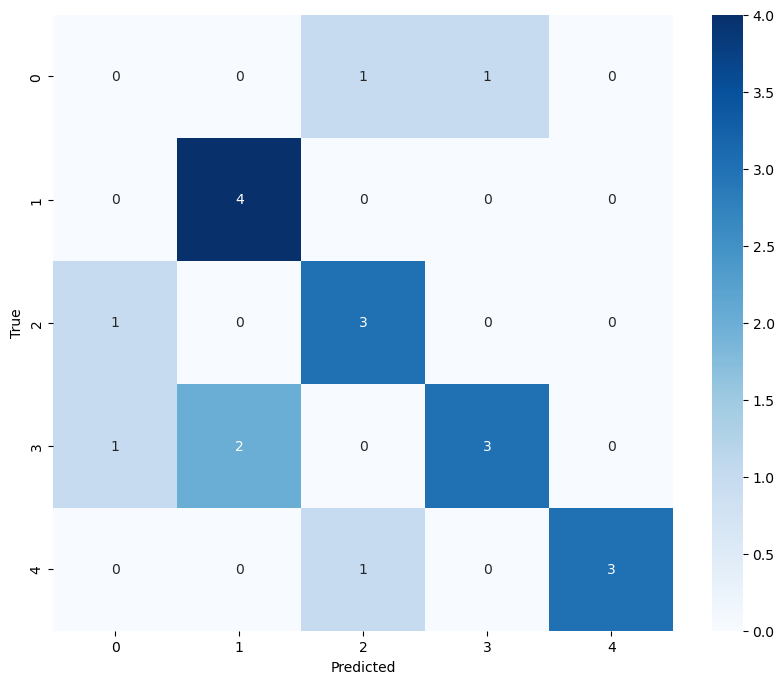

In [21]:
# Evaluate on the test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for videos, labels in DataLoader(test_dataset, batch_size=8, shuffle=False):
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### 6.2 Accuracy Graph

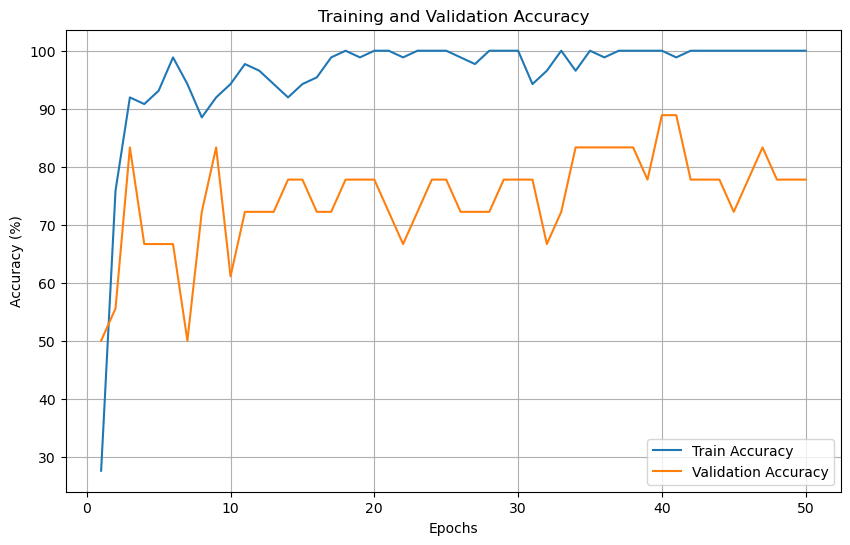

In [22]:
# Plot training/validation accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()
plt.show()


### 6.3 Evaluate the model on the test dataset 

In [23]:
# Evaluate the model on the test dataset
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

# Disable gradient calculation
with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device)

        # Forward pass
        outputs = model(videos)

        # Compute loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate average test loss and accuracy
test_loss /= len(test_loader)  # Average test loss
test_accuracy = 100 * correct / total  # Test accuracy as a percentage

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


C:\Users\Nhan Thai\AppData\Local\Temp\ipykernel_57416\2697291824.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  video_tensor = torch.load(video_path)


Test Loss: 1.2358
Test Accuracy: 65.00%


# 7. Save the Model

In [24]:
import os
import datetime as dt
import torch

# Define the format for date and time
date_time_format = "%Y_%m_%d__%H_%M_%S"
current_date_time = dt.datetime.now().strftime(date_time_format)

# Count the number of classes dynamically from the dataset directory
class_counts = {
    class_name: len(os.listdir(os.path.join(output_folder, class_name)))
    for class_name in os.listdir(output_folder) if os.path.isdir(os.path.join(output_folder, class_name))
}
num_classes = len(class_counts)
print(f"Number of Classes: {num_classes}")

# Assume test_loss and test_accuracy are calculated after testing
# Example placeholders (ensure these are replaced with actual calculated values):
model_test_loss = test_loss  
model_test_accuracy = test_accuracy  

# Generate an optimized, descriptive file name for the model
model_file_name = (
    f"3D_CNN_Model_{num_classes}Classes_"
    f"{current_date_time}_"
    f"Loss{test_loss:.4f}_"
    f"Acc{test_accuracy:.2f}.pth"
)

# Save the model's state dictionary with the descriptive file name
torch.save(model.state_dict(), model_file_name)
print(f"Model saved as: {model_file_name}")


Number of Classes: 5
Model saved as: 3D_CNN_Model_5Classes_2025_01_08__15_33_30_Loss1.2358_Acc65.00.pth
